Upload test.zip, train.zip and validation.zip

In [1]:
!pip freeze > requirements.txt
!unzip /content/sample_data/test.zip -d /content/sample_data
!unzip /content/sample_data/train.zip -d /content/sample_data
!unzip /content/sample_data/validation.zip -d /content/sample_data


Archive:  /content/sample_data/test.zip
  inflating: /content/sample_data/test/malignant/894.jpg  
  inflating: /content/sample_data/test/malignant/804.jpg  
  inflating: /content/sample_data/test/malignant/778.jpg  
  inflating: /content/sample_data/test/malignant/992.jpg  
  inflating: /content/sample_data/test/malignant/852.jpg  
  inflating: /content/sample_data/test/malignant/836.jpg  
  inflating: /content/sample_data/test/malignant/85.jpg  
  inflating: /content/sample_data/test/malignant/934.jpg  
  inflating: /content/sample_data/test/malignant/808.jpg  
  inflating: /content/sample_data/test/malignant/994.jpg  
  inflating: /content/sample_data/test/malignant/62.jpg  
  inflating: /content/sample_data/test/malignant/792.jpg  
  inflating: /content/sample_data/test/malignant/713.jpg  
  inflating: /content/sample_data/test/malignant/641.jpg  
  inflating: /content/sample_data/test/malignant/866.jpg  
  inflating: /content/sample_data/test/malignant/706.jpg  
  inflating: /cont

In [2]:
# Set up CUDA in OS
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Import libabries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import time, os
import copy
from torch.utils.data import Subset
import random

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Check version of Pytorch
print("torch. __version__=", torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device=", device)

# Find out if a GPU is available
use_cuda = torch.cuda.is_available()
print("use_cuda=", use_cuda)

torch. __version__= 2.4.1+cu121
device= cuda
use_cuda= True


# 1) GET DATA
Here we classify if the skin has cancer symptoms or not.

We will use Skin Cancer dataset which is a large collection of multi-source dermatoscopic images of common pigmented skin lesions.

The original set has 10.000 images classified as either benign or malignant, but due to computer performance, the author only used 440 images of them.

In [4]:

# Set up path for data after downloading
BASE_DIR = "/content/sample_data/"
train_dir = os.path.join(BASE_DIR,"train")
test_dir = os.path.join(BASE_DIR,"test")
train_classa_dir = os.path.join(BASE_DIR,"train","benign")
train_classb_dir = os.path.join(BASE_DIR,"train","malignant")
test_classa_dir = os.path.join(BASE_DIR,"test","benign")
test_classb_dir = os.path.join(BASE_DIR,"test","malignant")


This is benign skin cancer


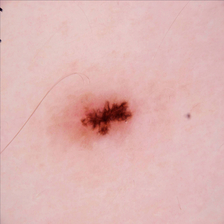

In [5]:

# Display image for reference
# white_torch = torchvision.io.read_image('C:/Users/Kirudang/Desktop/Assignment 2/Skin cancer dataset/test/benign/1.jpg')
white_torch = torchvision.io.read_image(os.path.join(test_classa_dir,"1.jpg"))
print("This is benign skin cancer")
T.ToPILImage()(white_torch)

This is malignant skin cancer


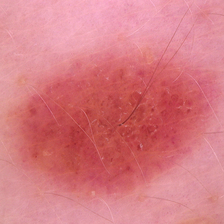

In [6]:
# Display image for reference
wh = torchvision.io.read_image(os.path.join(test_classa_dir,"44.jpg"))
print("This is malignant skin cancer")
T.ToPILImage()(wh)

# 2) Preprocess The Data
##a) transforms_train:
Used during training, where data augmentation techniques are applied to artificially increase the dataset size and diversity. This helps the model generalize better.

Transformations in transforms_train:
* transforms.Resize((224, 224)):

Resizes the input image to 224x224 pixels. This size matches the expected input dimensions of the ResNet model.
* transforms.RandomResizedCrop(224):

 Crops the image to 224x224 after resizing but does so randomly, introducing variation in the crop location and scale. This encourages the model to learn robust features regardless of object location.

* transforms.RandomHorizontalFlip():

Randomly flips the image horizontally with a 50% chance. This is a data augmentation technique that helps the model handle variations in object orientation.

* transforms.ToTensor():

Converts the image (a PIL Image or NumPy array) into a PyTorch tensor, rearranging dimensions from (H, W, C) to (C, H, W) and scaling pixel values to [0, 1].

* transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):

Normalizes the tensor image using the mean and standard deviation values calculated from the ImageNet dataset. These values align the input distribution with what the pre-trained model expects.


## b) transforms_test:
Used during testing/validation, where no data augmentation is applied, ensuring consistent evaluation.

Transformations in transforms_test:
* transforms.Resize((224, 224)):

Resizes the input image to 224x224 pixels.

* transforms.CenterCrop((224, 224)):

Crops the image to 224x224 pixels from the center. This ensures uniformity during testing, as the object is typically located near the center in most datasets.

* transforms.ToTensor():

Converts the image into a PyTorch tensor.

* transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):

Normalizes the image tensor using ImageNet’s mean and standard deviation values.

## Why Use These Transformations?
* Data Augmentation:

In the training pipeline, transformations like RandomResizedCrop and RandomHorizontalFlip introduce variations, preventing overfitting and making the model robust to unseen scenarios.

* Normalization:

Ensures that input images have a consistent range and distribution, matching the pre-trained model’s expectations. Models pre-trained on ImageNet require normalization with [0.485, 0.456, 0.406] for mean and [0.229, 0.224, 0.225] for standard deviation.

* Input Size:

Resizing to 224x224 ensures compatibility with the ResNet model, which was trained on images of this size.

In [7]:
# Create transform function
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


#Work with only small 320 train and 120 test dataset due to computing power
#limitation
train_dataset = datasets.ImageFolder(train_dir, transforms_train)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)
random.seed(42)
train_indices = random.sample(range(len(train_dataset)), 320)
test_indices = random.sample(range(len(test_dataset)), 120)
# Create subsets for training and testing
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)
# Create dataloaders for the subsets
train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=12, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_subset, batch_size=12, shuffle=False, num_workers=0)


print('Train dataset size:', len(train_subset))
print('Test dataset size:', len(test_subset))
class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 320
Test dataset size: 120
Class names: ['benign', 'malignant']


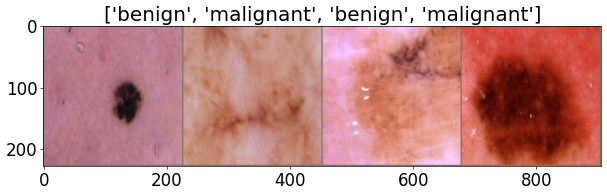

In [8]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
# load a batch of train image
iterator = iter(train_dataloader)
# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[5:9])
imshow(out, title=[class_names[x] for x in classes[5:9]])

# Pick up a pretrained model

In [9]:
model = models.resnet18(pretrained=True)
print("model=",model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


model= ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=T

**Customize model**

The customization consists of freezing the base model and changing the output layer to meet our requirements.

Check the output feature and add a newly fully-connected layer from the pre-trained model

As we can see, there are 512 output features from the original model; therefore, we need to change this by adding a fully connected layer for our classification problem with only 2 target classes.

In [10]:
num_features = model.fc.in_features
print('Number of features from pre-trained model', num_features)

# Add a fully-connected layer for classification
model.fc = nn.Linear(num_features, 2)
model = model.to(device)

Number of features from pre-trained model 512


##4) Train the model
As we have a customized classifier for our cancer problem, now we start to train our model.

To begin training, we define loss function and an optimizer first.

We’ll use Cross-Entropy loss for the loss function and SGD with momentum and lr=0.0001.

In [11]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

Due to limit in computation  resource, I ran 30 epochs for each set and saves the result of loss and accuracy in lists for further use.

We save our trained model for testing and future use.

This whole process took 1 minute on GPU.

In [12]:
#### Train model
train_loss=[]
train_accuary=[]
test_loss=[]
test_accuary=[]

num_epochs = 30   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    # Append result
    train_loss.append(epoch_loss)
    train_accuary.append(epoch_acc)
    # Print progress
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))
    """ Testing Phase """
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        # Append result
        test_loss.append(epoch_loss)
        test_accuary.append(epoch_acc)
        # Print progress
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time()- start_time))
#end for

save_path = 'custom-classifier_resnet_18_final.pth'
torch.save(model.state_dict(), save_path)


Epoch 0 running
[Train #1] Loss: 0.0095 Acc: 8.3293% Time: 4.6157s
[Test #1] Loss: 0.0119 Acc: 8.7879% Time: 5.2098s
Epoch 1 running
[Train #2] Loss: 0.0078 Acc: 10.2070% Time: 7.8532s
[Test #2] Loss: 0.0103 Acc: 11.2121% Time: 8.2729s
Epoch 2 running
[Train #3] Loss: 0.0073 Acc: 11.1218% Time: 10.6581s
[Test #3] Loss: 0.0090 Acc: 12.2727% Time: 11.0943s
Epoch 3 running
[Train #4] Loss: 0.0066 Acc: 11.6033% Time: 13.4485s
[Test #4] Loss: 0.0084 Acc: 12.5758% Time: 13.8856s
Epoch 4 running
[Train #5] Loss: 0.0060 Acc: 11.8922% Time: 18.7086s
[Test #5] Loss: 0.0081 Acc: 12.8788% Time: 19.3464s
Epoch 5 running
[Train #6] Loss: 0.0060 Acc: 11.9403% Time: 21.8261s
[Test #6] Loss: 0.0079 Acc: 13.6364% Time: 22.2572s
Epoch 6 running
[Train #7] Loss: 0.0058 Acc: 11.9884% Time: 24.6384s
[Test #7] Loss: 0.0077 Acc: 13.6364% Time: 25.0595s
Epoch 7 running
[Train #8] Loss: 0.0057 Acc: 11.8440% Time: 27.3883s
[Test #8] Loss: 0.0073 Acc: 13.9394% Time: 27.8154s
Epoch 8 running
[Train #9] Loss: 0.005

##5) Evaluate model

* Overall performance and when to stop
From the log, we can see that our model performs pretty well on the new dataset. However, to evaluate its performance through time, let take a look at our plot.

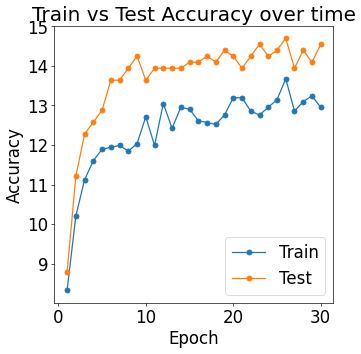

In [13]:
# Plot
plt.figure(figsize=(6,6))
plt.plot(np.arange(1,num_epochs+1), train_accuary,'-o')
plt.plot(np.arange(1,num_epochs+1), test_accuary,'-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy over time')
plt.show()

* Class performance

To check the performance of each class, lets a confusion matrix and heatmap plot for observation.

Accuracy on Training set:  0.8
Confusion matrix: 
 [[1800  120]
 [ 600 1080]]
Classification report: 
               precision    recall  f1-score   support

           0       0.75      0.94      0.83      1920
           1       0.90      0.64      0.75      1680

    accuracy                           0.80      3600
   macro avg       0.82      0.79      0.79      3600
weighted avg       0.82      0.80      0.79      3600



<Axes: title={'center': 'Confusion matrix for Skin Cancer classification '}>

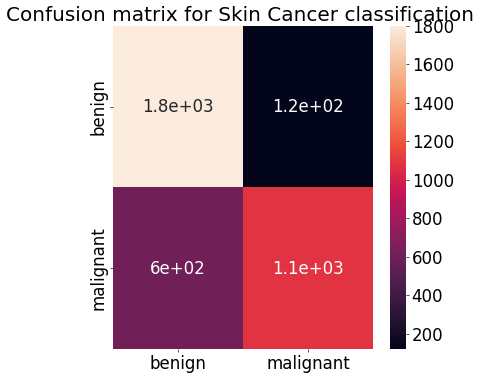

In [14]:
# Get data to check on the performance of each label
y_pred = []
y_true = []

num_epochs = 30   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs) # Feed Network
            outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(outputs) # Save Prediction
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth
#end for

# Visualization and result
# constant for classes
classes = test_dataset.classes
# Build confusion matrix
print("Accuracy on Training set: ",accuracy_score(y_true, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_true, y_pred))
print('Classification report: \n', classification_report(y_true, y_pred))
# Plot
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (7,7))
plt.title("Confusion matrix for Skin Cancer classification ")
sn.heatmap(df_cm, annot=True)
